In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import parameters_to_vector
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from preds.models import MLPS

from preds.likelihoods import CategoricalLh
from preds.datasets import UCIClassificationDatasets
from preds.laplace import Laplace

Includes some playing around with the Immer et al. dataset and model classes and a script for running the UCI experiemnts (with hyperparameters as in the paper appendix)

Testing the dataset and model classes

In [ ]:
width = 50 # as in Immer et al. 
depth = 2 # as in Immer et al. 
prior_prec = np.logspace(-2, 2, num=10)[0] # as in Immer et al. but depends on dataset
lr = 1e-3 # as in Immer et al. 
n_epochs = 10000
n_samples = 1000
train_size = 0.70 # as in Immer et al. 
lh = CateoricalLh()  
uci_dataset = 'glass'
root_dir = '../data/'
device = 'cpu'

Load training data

In [ ]:
ds_train = UCIClassificationDatasets(train=True, data_set=uci_dataset, split_train_size=train_size, double=False, root=root_dir)
X_train, y_train = ds_train.data.to(device), ds_train.targets.to(device).unsqueeze(1)
train_loader = [(X_train, y_train)]  

Load validation data

In [ ]:
ds_val = UCIClassificationDatasets(train=False,valid=True, data_set=uci_dataset, split_train_size=train_size, double=False, root=root_dir)
X_val, y_val = ds_val.data.to(device), ds_val.targets.to(device).unsqueeze(1)
val_loader = [(X_val, y_val)] 

In [ ]:
X_train.shape

In [ ]:
model = MLPS(X_train.shape[1], [width]*depth, 1, activation='tanh', flatten=False).to(device)
optim = Adam(model.parameters(), lr=lr)
losses = list()
for i in range(n_epochs):
    f = model(X_train)
    w = parameters_to_vector(model.parameters())
    reg = 0.5 * prior_prec * w @ w
    loss = - lh.log_likelihood(y_train, f) + reg
    loss.backward()
    optim.step()
    losses.append(loss.item())
    model.zero_grad()


In [ ]:
lap = Laplace(model, float(prior_prec), lh)


def get_pred_for(x, model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(x, n_samples=n_samples)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(x, n_samples=n_samples)
        mu = samples.mean(axis=0)
        var = samples.cov(axis=0)
    else:
        raise ValueError('unsupported model_type.')
    mu = mu.detach().cpu().squeeze()
    var = var.detach().cpu().squeeze()
    return mu, var

In [ ]:
print(X_train.dtype)
print(X_val.dtype)
print(mu.dtype)

In [ ]:
# GLM

mu_glm, var_glm = get_pred_for(X_val, 'glm', 'full')# runs
# mu_glm_kron, var_glm_kron = get_pred_for(X_val, 'glm', 'kron') # doesn't run
#mu, var = get_pred_for(X_val, 'glm', 'diag')# doesn't run

# BNN
mu_bnn, var_bnn = get_pred_for(X_val, 'bnn', 'full')

In [ ]:
y_val.shape

In [ ]:
lh_glm = Normal(mu_glm, var_glm)
print(-torch.mean(lh_glm.log_prob(y_val.squeeze(-1))))

In [ ]:
lh_bnn = Normal(mu_bnn, var_bnn)
print(-torch.mean(lh_bnn.log_prob(y_val.squeeze(-1))))

<h2>Run the classification pipeline for chosen dataset </h2>

The classification.py script tests 10 options for the prior precision, with a fixed train/val/test split. The results reported in the paper are over 10 different train/val/test splits

In [8]:
datasets = ['australian', 'breast_cancer', 'digits', 'glass',
            'ionosphere', 'satellite', 'vehicle', 'waveform']
seeds = [711, 1, 75, 359, 17, 420, 129, 666, 69, 36]
dataset = 'breast_cancer'

In [ ]:
for seed in seeds:
    if dataset in ['satellite', 'digits']:
        logmin = -1.0
    else:
        logmin = -2.0
    !python3 ../experiments/classification.py -d {dataset} --root_dir ../ --seed {seed} --n_layers 2 --activation tanh --name tanh_2 --logd_min {logmin}

Writing results to ../experiments/results
Reading data from ../data
100%|██████████████████████████████████████████| 10/10 [42:12<00:00, 253.22s/it]
Writing results to ../experiments/results
Reading data from ../data
100%|██████████████████████████████████████████| 10/10 [53:43<00:00, 322.32s/it]
Writing results to ../experiments/results
Reading data from ../data
100%|██████████████████████████████████████████| 10/10 [44:43<00:00, 268.37s/it]
Writing results to ../experiments/results
Reading data from ../data
 60%|█████████████████████████▊                 | 6/10 [24:45<16:41, 250.35s/it]

The experiment in experiments/uci_classification_commands.py could otherwise be used, but it does not take into account the different hyperparameter settings required for satellite & digits datasets (different range for prior precision)

<h2> Manual reading of the result pickle</h2>
Read the result pickle (for a single experiment with various prior precisions)

Find  which prior precision gives the best validation NLL for the dataset (based on average NLL performance)

In [7]:
def get_val_best(result_list, model_name='svgp_ntk'):
    valid_nlls = np.zeros((len(result_list), len(result_list[0]['deltas'])))
    for i, results in enumerate(result_list):
        for j, res in enumerate(results['results']):
            if f'valid_nll_{model_name}' not in res:
                continue
            valid_nlls[i, j] = res[f'valid_nll_{model_name}']
    mean_nlls = np.mean(valid_nlls, axis=0)
    min_nll = mean_nlls.min()
    min_index = list(mean_nlls).index(min_nll)
    return min_index

def get_result_list(dataset,folder_name,  name, seeds):   
    result_list = []
    for seed in seeds:
        file_name = f'../experiments/results/uci/{folder_name}/classification_{dataset}_{name}_{seed}.pkl'
        if os.path.isfile(file_name):
            with open(file_name, 'rb') as handle:
                result_list.append(pickle.load(handle))
        else:
            print(f'WARNING: No results for seed {seed}, dataset {dataset}')
    return result_list

Check the test set performance of the selected prior precision

In [8]:
def get_test_mean_std(result_list, min_idx, name='svgp_ntk'):
    test_nlls = np.zeros(len(result_list))
    for i, results in enumerate(result_list):
        test_nlls[i] = results['results'][min_idx][f'test_nll_{name}']
    mean = np.mean(test_nlls)
    std = np.std(test_nlls)
    return (mean, std)

<h2>Automatic table creation </h2>

In [9]:
method_map = {
    'NN MAP':  [(0.31, 0.01), (0.11, 0.02), (0.35, 0.02), (0.95,0.03), (0.420, 0.007), (0.335, 0.004), (0.094, 0.003), (0.230, 0.002)],
'MFVI': [(0.34, 0.01), (0.11, 0.01), (0.41, 0.01), (1.06,0.01), (0.504, 0.006), (0.393, 0.003), (0.219, 0.004), (0.307, 0.002)],
'BNN' : [(0.42, 0.00), (0.19, 0.00), (0.50, 0.00), (1.41,0.00), (0.885, 0.002), (0.516, 0.002), (0.875, 0.002), (0.482, 0.001)],
'GLM' : [(0.32, 0.02), (0.10, 0.01), (0.29, 0.01), (0.86,0.01), (0.428, 0.005), (0.339, 0.004), (0.250, 0.002), (0.241, 0.001)],
#'GLM diag' : [(0.33, 0.01), (0.11, 0.01), (0.35, 0.01), (0.99,0.01), (0.618, 0.003), (0.388, 0.003), (0.409, 0.002), (0.327, 0.002)],
#'GLM refine' :[(0.32, 0.02), (0.11, 0.01), (0.35, 0.05), (0.98,0.07), (0.402, 0.007), (0.335, 0.004), (0.150, 0.002), (0.227, 0.002)],
#'GLM refine d' : [(0.31, 0.01), (0.12, 0.02), (0.32, 0.03), (0.83,0.02), (0.432, 0.005), (0.364, 0.008), (0.149, 0.008), (0.248, 0.002)],
}


In [161]:
'valid_nll_svgp_ntk' in result_list[5]['results'][4].keys()

True

In [24]:
import os
import pickle
inducing_points = [16, 32, 64, 128,256,  'all'] #, 32, 64, 128, 256, 'all']# [16, 32, 64, 128, 'all']
folder_name = '16'
pretty_names = {'sparse_16_svgp_ntk': 'SVGP (16)',
                'sparse_32_svgp_ntk': 'SVGP (32)',
                'sparse_64_svgp_ntk': 'SVGP (64)',
                'sparse_128_svgp_ntk': 'SVGP (128)',
                'sparse_256_svgp_ntk': 'SVGP (256)',
                'sparse_all_svgp_ntk': 'GP all',
                'sparse_16_svgp_ntk_nn': 'SVGP NN (16)',
                'sparse_32_svgp_ntk_nn': 'SVGP NN (32)',
                'sparse_64_svgp_ntk_nn': 'SVGP NN (64)',
                'sparse_128_svgp_ntk_nn': 'SVGP NN (128)',
                'sparse_256_svgp_ntk_nn': 'SVGP NN (256)',
               'sparse_16_gp_subset': 'GP subset(16)',
               'sparse_32_gp_subset': 'GP subset(32)',
               'sparse_64_gp_subset': 'GP subset(64)',
               'sparse_128_gp_subset': 'GP subset(128)',          
               'sparse_256_gp_subset': 'GP subset(256)',
                'sparse_all_gp_subset': 'GP all (subset)',
                'sparse_all_svgp_ntk_nn': 'GP NN all',
               'sparse_16_gp_subset_nn': 'GP NN subset(16)',
               'sparse_32_gp_subset_nn': 'GP NN subset(32)',
               'sparse_64_gp_subset_nn': 'GP NN subset(64)',
               'sparse_128_gp_subset_nn': 'GP NN subset(128)',
               'sparse_256_gp_subset_nn': 'GP NN subset(256)',}
method_names = ['svgp_ntk', 'gp_subset', 'gp_subset_nn', 'svgp_ntk_nn']
datasets = ['australian', 'breast_cancer', 'ionosphere','glass',
            'vehicle','waveform', 'digits', 'satellite']
data_names = ['australian', 'cancer', 'ionosphere', 'glass', 'vehicle', 'waveform', 'digits', 'satellite']
seeds = [711, 1, 75, 359, 17, 420, 129, 666, 69, 36]
for n_inducing in inducing_points:
    print(f'Gathering results for {n_inducing}')
    exp_name = f'sparse_{n_inducing}'
    for method_name in method_names:
        table_list = []
        if n_inducing == 'all' and 'gp_subset_nn' == method_name:
            continue
        for dataset in datasets:
         #   print(dataset)
            result_list = get_result_list(dataset, folder_name, exp_name, seeds)
            if len(result_list) < 10:
                print(f'WARNING: N seeds for {dataset}:')
                print(len(result_list))
                table_list.append((0, 0))
                continue
            min_idx = get_val_best(result_list, method_name)
            (mean, std) = get_test_mean_std(result_list, min_idx, name=method_name)
            table_list.append((round(mean, 3), round(std, 3)))
        method_map[pretty_names[f'sparse_{n_inducing}_{method_name}']] = table_list
        

Gathering results for 16
Gathering results for 32
Gathering results for 64
Gathering results for 128
Gathering results for 256
Gathering results for all


In [46]:
method_map

{'NN MAP': [(0.31, 0.01),
  (0.11, 0.02),
  (0.35, 0.02),
  (0.95, 0.03),
  (0.42, 0.007),
  (0.335, 0.004),
  (0.094, 0.003),
  (0.23, 0.002)],
 'MFVI': [(0.34, 0.01),
  (0.11, 0.01),
  (0.41, 0.01),
  (1.06, 0.01),
  (0.504, 0.006),
  (0.393, 0.003),
  (0.219, 0.004),
  (0.307, 0.002)],
 'BNN': [(0.42, 0.0),
  (0.19, 0.0),
  (0.5, 0.0),
  (1.41, 0.0),
  (0.885, 0.002),
  (0.516, 0.002),
  (0.875, 0.002),
  (0.482, 0.001)],
 'GLM': [(0.32, 0.02),
  (0.1, 0.01),
  (0.29, 0.01),
  (0.86, 0.01),
  (0.428, 0.005),
  (0.339, 0.004),
  (0.25, 0.002),
  (0.241, 0.001)],
 'SVGP (16)': [(0.331, 0.025),
  (0.113, 0.028),
  (0.364, 0.035),
  (1.004, 0.077),
  (0.578, 0.023),
  (0.362, 0.023),
  (0.516, 0.018),
  (0.379, 0.014)],
 'GP subset(16)': [(0.573, 0.014),
  (0.474, 0.036),
  (0.597, 0.016),
  (1.255, 0.029),
  (1.143, 0.02),
  (0.7, 0.034),
  (1.888, 0.037),
  (1.312, 0.047)],
 'GP NN subset(16)': [(0.335, 0.021),
  (0.11, 0.026),
  (0.353, 0.044),
  (1.017, 0.075),
  (0.604, 0.017),
  (

In [64]:
import os
import scipy.stats as stats
paper_methods = ['NN MAP', 'MFVI', 'BNN', 'GLM', 'GP subset(256)', 'SVGP (256)', 'GP NN subset(256)', 'SVGP NN (256)', 'GP all']
paper_methods = ['NN MAP', 'MFVI', 'BNN', 'GLM', 'SVGP ', 'GP all',  'GP subset', 'GP NN subset', 'SVGP ',  'SVGP NN ']
pretty_names = ['NN MAP', 'MFVI', 'BNN', 'GLM', r'\our', 'Full GP', 'GP subset',  'GP subset', r'\our', r'\our', ]
dataset_to_subset = {'australian':256,
                    'cancer':256,
                    'ionosphere':256, 
                     'glass':256,
                     'vehicle':256, 
                     'waveform':256,
                     'digits':256, 
                     'satellite':256}
all_methods = list(method_map.keys())
appendix_methods = []
for method in all_methods:
    if method not in paper_methods and method != 'GP all (subset)':
        appendix_methods.append(method)
appendix_methods.append('GP all')
print(f'Writing to paper: {paper_methods}')
print(f'Writing to appendix: {appendix_methods}')

def is_significant(mean, std_dev, means, std_devs):
    idx_max = np.argmin(means)
    s = stats.ttest_ind_from_stats(means[idx_max], std_devs[idx_max], 10, mean,  std_dev, 10, equal_var=False)
    return s.pvalue > 0.05

lines = []
lines.append(r'\begin{tabular}{l C{\tblw} C{\tblw} C{\tblw} C{\tblw}  C{\tblw} || C{\tblw} C{\tblw} C{\tblw} C{\tblw}  C{\tblw}  C{\tblw}} \\')
lines.append(r'\toprule')
lines.append(r'& \multicolumn{5}{c}{}')
lines.append(r'& \multicolumn{5}{c}{Ablations ($M=32$)}')
lines.append(r'\\ ')
header_str = 'Method '
for method_name in pretty_names:
    header_str += f'& {method_name} '
header_str += r' \\'
lines.append(header_str)

header_str = 'Mean from '
print(len(pretty_names))
print(len(paper_methods))
for method_name in paper_methods:
    if 'NN' in method_name and method_name not in ['NN MAP', 'BNN']:
        mean = 'NN'
    elif 'GP' in method_name or 'our' in method_name:
        mean = 'GP'
    else:
        mean = ''
    header_str += f'& {mean}'
header_str += r' \\'
lines.append(header_str)
lines.append(r'\midrule')
for i, data_name in enumerate(data_names):
    subset_size = dataset_to_subset[data_name]
    subset_size_abl = 32
    line_str = f'\sc {data_name} &'
    moments_1 = np.zeros((5, 2))
    moments_2 = np.zeros((5, 2))
    for j, method_name in enumerate(paper_methods):
        if method_name in ['GP all', 'GP NN all'] :
            method_key = method_name
        elif 'GP' not in method_name:
            method_key = method_name
        elif j == 4:
            print('Using full')
            method_key = f'{method_name}({subset_size})'
        else:
            method_key = f'{method_name}({subset_size_abl})'
        (mean, var) = method_map[method_key][i]
        if j <= 4:
            moments_1[j, 0] = mean
            moments_1[j, 1] = var
        else:
            moments_2[j-5, 0] = mean
            moments_2[j-5, 1] = var
    
    for j, method_name in enumerate(paper_methods):
        if j <= 4:
            mean = moments_1[j, 0] 
            var = moments_1[j, 1]
            bold = is_significant(mean, var, moments_1[:, 0], moments_1[:, 1])
        else:
            mean = moments_2[j-5, 0]
            var = moments_2[j-5, 1]
            bold = is_significant(mean, var, moments_2[:, 0], moments_2[:, 1])
        line_str += ' '
        mean = '{:.2f}'.format(mean)
        var = '{:.2f}'.format(var).lstrip('0')
        line_str += r'\val{'
        if bold:
            line_str += r'\textbf {'
        line_str += str(mean)
        if bold:
            line_str += r'}'
        line_str += '}{'
        line_str += str(var)
        line_str += '}'
        line_str += ' &'
    line_str = line_str[:-2]
    line_str += r' \\'
    lines.append(line_str) 
lines.append(r'\bottomrule')
lines.append(r'\end{tabular}')
tex_file = 'uci.tex'
os.remove(tex_file)
with open(tex_file, 'a') as file:
    for line in lines:
        file.write(line+'\n')
    
print(lines)

Writing to paper: ['NN MAP', 'MFVI', 'BNN', 'GLM', 'SVGP ', 'GP all', 'GP subset', 'GP NN subset', 'SVGP ', 'SVGP NN ']
Writing to appendix: ['SVGP (16)', 'GP subset(16)', 'GP NN subset(16)', 'SVGP NN (16)', 'SVGP (32)', 'GP subset(32)', 'GP NN subset(32)', 'SVGP NN (32)', 'SVGP (64)', 'GP subset(64)', 'GP NN subset(64)', 'SVGP NN (64)', 'SVGP (128)', 'GP subset(128)', 'GP NN subset(128)', 'SVGP NN (128)', 'SVGP (256)', 'GP subset(256)', 'GP NN subset(256)', 'SVGP NN (256)', 'GP NN all', 'GP all']
10
10
Using full
Using full
Using full
Using full
Using full
Using full
Using full
Using full
['\\begin{tabular}{l C{\\tblw} C{\\tblw} C{\\tblw} C{\\tblw}  C{\\tblw} || C{\\tblw} C{\\tblw} C{\\tblw} C{\\tblw}  C{\\tblw}  C{\\tblw}} \\\\', '\\toprule', '& \\multicolumn{5}{c}{}', '& \\multicolumn{5}{c}{Ablations (M=32)}', '\\\\ ', 'Method & NN MAP & MFVI & BNN & GLM & \\our & Full GP & GP subset & GP subset & \\our & \\our  \\\\', 'Mean from & & & & & GP& GP& GP& NN& GP& NN \\\\', '\\midrule', 

In [26]:
lines = []
lines.append(r'\begin{tabular}{l l C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw}}')
lines.append(r'\toprule')
header_str = ''
pretty_names = ['SVGP', 'SVGP NN', 'GP subset', 'GP NN subset']
for method_name in pretty_names:
    header_str += f'& {method_name} '
header_str += r' \\'
lines.append(header_str)
lines.append(r'\midrule')
for ind_point in inducing_points[:-1]:
    
    lines.append(r'\multirow{2}{*}{'+ str(ind_point) +'}')
    for i, data_name in enumerate(data_names):
        line_str = f'\sc {data_name} &'
        for method_name in appendix_methods:
            if str(ind_point) not in method_name:
                continue
            (mean, var) = method_map[method_name][i]
            mean_var = f'{mean} {var}'
            line_str += r' \val{'
            line_str += str(mean)
            line_str += '}{'
            line_str += str(var)
            line_str += '} &'
        line_str = line_str[:-2]
        line_str += r' \\'
        lines.append(line_str)    
    lines.append(r'\midrule')
lines.append(r'\bottomrule')
lines.append(r'\end{tabular}')
tex_file = 'uci_all.tex'
os.remove(tex_file)
with open(tex_file, 'a') as file:
    for line in lines:
        file.write(line+'\n')
    
print(lines)

['\\begin{tabular}{l l C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw} C{0.6\\tblw}}', '\\toprule', '& SVGP & SVGP NN & GP subset & GP NN subset  \\\\', '\\midrule', '\\multirow{2}{*}{16}', '\\sc australian & \\val{0.331}{0.025} & \\val{0.573}{0.014} & \\val{0.335}{0.021} & \\val{0.319}{0.029} \\\\', '\\sc cancer & \\val{0.113}{0.028} & \\val{0.474}{0.036} & \\val{0.11}{0.026} & \\val{0.096}{0.035} \\\\', '\\sc ionosphere & \\val{0.364}{0.035} & \\val{0.597}{0.016} & \\val{0.353}{0.044} & \\val{0.302}{0.054} \\\\', '\\sc glass & \\val{1.004}{0.077} & \\val{1.255}{0.029} & \\val{1.017}{0.075} & \\val{0.901}{0.071} \\\\', '\\sc vehicle & \\val{0.578}{0.023} & \\val{1.143}{0.02} & \\val{0.604}{0.017} & \\val{0.496}{0.018} \\\\', '\\sc waveform & \\val{0.362}{0.023} & 

In [13]:
nll_dict = {}
for i, dataset in enumerate(datasets):
    dataset_nlls = np.zeros((len(inducing_points) -1, 4))
    for j, n_inducing in enumerate(inducing_points):
        if n_inducing == 'all':
            continue
        name = f'SVGP ({n_inducing})'
        if n_inducing == 'all':
            name = 'GP all'
            
        svgp_res = method_map[name][i][0]
        subset_name = f'GP subset({n_inducing})'
        if n_inducing == 'all':
            subset_name = 'GP all'
        
        subset_res = method_map[subset_name][i][0]
        svgp_nn_name = f'SVGP NN ({n_inducing})'
        svgp_nn_res = method_map[svgp_nn_name][i][0]
        
        gp_nn_name = f'GP NN subset({n_inducing})'
        gp_nn_res = method_map[gp_nn_name][i][0]
        
        dataset_nlls[j][0] = svgp_res
        dataset_nlls[j][1] = subset_res
        dataset_nlls[j][2] = svgp_nn_res
        dataset_nlls[j][3] = gp_nn_res
    nll_dict[dataset] = dataset_nlls
    

In [18]:
import matplotlib.pyplot as plt
import tikzplotlib


/var/folders/mb/q209wf797q9b2mggmld8bt8w0000gp/T/ipykernel_7284/2777782799.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] +inducing_points[:-1])


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

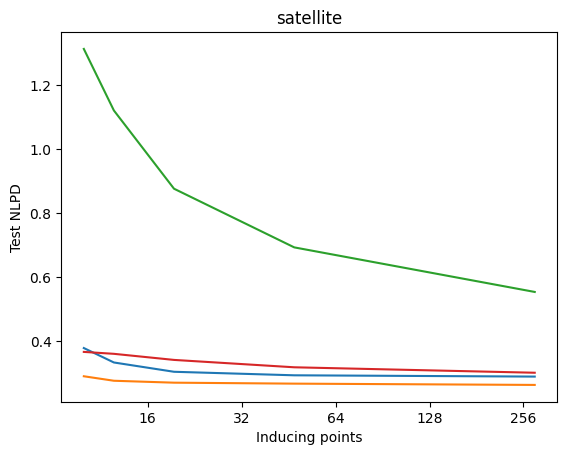

In [23]:
for dataset in nll_dict:
    plt.clf()
    fig, ax = plt.subplots()
    res_array = nll_dict[dataset]
    svgp_res = res_array[:, 0]
    subset_res = res_array[:, 1]
    svgp_nn_res = res_array[:, 2]
    gp_nn_res = res_array[:, 3]
    ind_points = inducing_points[:-1]
    plt.plot(ind_points, svgp_res, label='SVGP')
    plt.plot(ind_points, svgp_nn_res, label='SVGP NN')
    plt.plot(ind_points, subset_res, label='GP subset')
    plt.plot(ind_points, gp_nn_res, label='GP NN subset')
    ax.set_xticklabels([0] +inducing_points[:-1])
    plt.title(dataset)
    plt.xlabel('Inducing points')
    plt.ylabel('Test NLPD')
   # plt.legend()
    plt.savefig(f'plots/{dataset}.png', bbox_inches='tight')
    tikzplotlib.save(f'plots/{dataset}.tex', figure=fig)

In [355]:
logd_min, logd_max, n_deltas = 2, 3, 16
deltas = np.logspace(logd_min, logd_max, n_deltas)
print(deltas)
print(np.log10(116))
print(np.log10(300))

[ 100.          116.59144012  135.93563909  158.48931925  184.78497974
  215.443469    251.18864315  292.86445646  341.45488738  398.10717055
  464.15888336  541.16952655  630.95734448  735.64225446  857.69589859
 1000.        ]
2.0644579892269186
2.4771212547196626


<h2>Create img result table </h2>

In [614]:
def get_val_best_img(result_list, deltas, model_name='svgp_ntk'):
    print(model_name)
    valid_nlls = [] #np.zeros((len(result_list), len(deltas)))
    for i, results in enumerate(result_list):
        seed_list = []
        for j, delta in enumerate(deltas):
            if delta not in results:
                print(f'Warning: missing {delta} for seed index {i}')
                continue
            seed_list.append(results[delta]['nll_va'])
           # valid_nlls[i, j] = valid_res
        valid_nlls.append(seed_list)
    

    mean_nlls = np.array(pd.DataFrame(valid_nlls).mean(axis = 0))
   # mean_nlls = np.mean(valid_nlls, axis=0)
   # mean_nlls = np.array([np.mean([x[i] for x in valid_nlls]) for i in range(len(deltas))])
    print(mean_nlls)
    min_nll = mean_nlls.min()
    min_index = list(mean_nlls).index(min_nll)
    return min_index

def get_result_list_img(res_folder, dataset, seeds, name='sparse_1000', model='MLP', method_name='svgp_ntk'):   
    result_list = []
    deltas = []
    dir_name = f'../experiments/results/{dataset}/{res_folder}/svgp_runs/'
    for seed in seeds:
        seed_res = dict()
        for file in os.listdir(dir_name):
            if file[-4:] == '.pkl':
                continue
            s, delta = file[:-3].split('_')
          #  ds, m, s, delta = file[:-3].split('_')
         #   if m != model:
          #      continue
            if int(s) != seed:
                continue
            state = torch.load(os.path.join(dir_name, file), map_location=torch.device('cpu'))
        #    if ds == 'FMNIST':
         #       print(state.keys())
            if f'{method_name}_{name}' not in state:
                continue
            seed_res[delta] = state[f'{method_name}_{name}']
            deltas.append(delta)
        if len(seed_res) > 0:
            result_list.append(seed_res)
    deltas = list(set(deltas))
    print(f'N seeds: {len(result_list)}')
    return result_list, deltas

def get_ood_auc(test_results, res_folder, dataset, seeds, name='sparse_1000', model='MLP', method_name='svgp_ntk'):
    dir_name = f'../experiments/results/{dataset}/{res_folder}'
    ood_results = []
    for seed in seeds:
         for file in os.listdir(dir_name):
            if file == 'models':
                continue
            ds, m, s,  *extras, blah = file[:-4].split('_')
            if m != model:
                continue
            if int(s) != seed:
                continue
            exp_name = '_'.join(extras)
         #   print(exp_name)
            if exp_name != name:
                continue
        #    print(file)
            with open(os.path.join(dir_name, file), 'rb') as handle:
                state = pickle.load(handle)
            if method_name not in state:
                continue
            ood_res = state[f'{method_name}']['ood']
            ood_results.append(ood_res)
    ood_results = np.array(ood_results)
    if len(ood_results) < 4:
        test_results['ood-auc'].append((0.0, 0.0))
        return test_results
    ood_mean = round(np.mean(ood_results), 3)
    ood_std = round(np.std(ood_results), 3)
    test_results['ood-auc'].append((ood_mean, ood_std))
    return test_results
            
                          
def get_test_mean_std_img(result_list, deltas, min_idx, metrics, test_results):
    min_delta = deltas[min_idx]
    for metric in metrics:
        test_nlls = []
        for i, results in enumerate(result_list):
            if f'{metric}_te' not in results[min_delta]:
                continue
            metric_val = results[min_delta][f'{metric}_te']    
            if metric == 'acc':
                metric_val = metric_val * 100
            test_nlls.append(metric_val)
        if len(test_nlls) < 4:
            continue
        test_nlls = np.array(test_nlls)
        mean = np.mean(test_nlls)
        std = np.std(test_nlls)
        test_results[metric].append((round(mean, 3), round(std, 3)))
    return test_results

In [615]:
method_map_img = {
    'MAP': {'nll': [(0.258, 0.004), (0.605, 0.007)] , 'ece': [(0.017, 0.001), (0.066, 0.004)], 'acc':[(91.39, 0.11), (80.92, 0.32)], 'ood-auc': [(0.864, 0.014), (0.792, 0.008)]} ,
'BNN predictive': {'nll': [(0.942, 0.016), (2.114, 0.021)] , 'ece': [(0.411, 0.008), (0.095, 0.012)], 'acc':[(84.42, 0.12), (21.74, 0.80)], 'ood-auc': [(0.945, 0.002), (0.689, 0.020)]} ,
'BNN predictive (Ritter et al.)' : {'nll': [(0.265, 0.004), (0.588, 0.005)] , 'ece': [(0.024, 0.002), (0.052, 0.005)], 'acc':[(91.20, 0.07), (80.78, 0.36)], 'ood-auc': [(0.947, 0.006), (0.783, 0.007)]}  ,
'GLM predictive' :{'nll': [(0.244, 0.003), (0.601, 0.008)] , 'ece': [(0.012, 0.003), (0.084, 0.010)], 'acc':[(92.25, 0.10), (81.37, 0.15)], 'ood-auc': [(0.955, 0.006), (0.843, 0.016)]}  ,
'GP predictive' : {'nll': [(0.250, 0.004), (0.555, 0.008)] , 'ece': [(0.007, 0.001), (0.017, 0.003)], 'acc':[(91.36, 0.11), (81.01, 0.32)], 'ood-auc': [(0.918, 0.010), (0.820, 0.013)]} ,}

In [616]:
exper_names = ['sparse_100_eps_small', 'sparse_500_eps_small', 'sparse_1000_eps_small', 'sparse_3200_eps_small']
pretty_names = {'sparse_100_eps_small_svgp_ntk': 'SVGP (100)',
               'sparse_100_eps_small_svgp_ntk_nn': 'SVGP NN (100)',
               'sparse_500_eps_small_svgp_ntk': 'SVGP (500)',
               'sparse_500_eps_small_svgp_ntk_nn': 'SVGP NN (500)',
               'sparse_1000_eps_small_svgp_ntk': 'SVGP (1000)',
               'sparse_1000_eps_small_svgp_ntk_nn': 'SVGP NN (1000)',
               'sparse_3200_eps_small_svgp_ntk': 'SVGP (3200)',
               'sparse_3200_eps_small_svgp_ntk_nn': 'SVGP NN (3200)'}
method_names = ['svgp_ntk', 'svgp_ntk_nn']
datasets = ['FMNIST']
dataset_to_res = {'FMNIST': '15_2', 'CIFAR10': '13'}
model = 'CNN'
data_names = ['FMNIST', 'CIFAR10']
metrics = ['acc', 'nll', 'ece', 'ood-auc']
seeds = [117, 68, 187, 27, 51]
for exp_name in exper_names:
    for method_name in method_names:
        table_list = []
        print(method_name)
        print(exp_name)
        test_results = dict()
        for metric in metrics:
            test_results[metric] = []
        for dataset in datasets:
            res_folder = dataset_to_res[dataset]
            print(dataset)
            result_list, deltas = get_result_list_img(res_folder, dataset,  seeds, name=exp_name,  model=model, method_name=method_name)
            print(f'N_deltas: {len(deltas)}')
            print(f'N seeds: {len(result_list)}')
            if len(result_list) == 0:
                print(f'No results: continue')
                for metric in metrics:
                    test_results[metric].append((0, 0))
                continue
            min_idx = get_val_best_img(result_list, deltas)
            test_results = get_test_mean_std_img(result_list, deltas,  min_idx, metrics, test_results)
            print(test_results)
          #  test_results = get_ood_auc(test_results, res_folder, dataset, seeds, name=exp_name, model=model, method_name=method_name)
            print(test_results)
        method_map_img[pretty_names[exp_name+'_'+method_name]] = test_results

svgp_ntk
sparse_100_eps_small
FMNIST
N seeds: 0
N_deltas: 0
N seeds: 0
No results: continue
svgp_ntk_nn
sparse_100_eps_small
FMNIST
N seeds: 0
N_deltas: 0
N seeds: 0
No results: continue
svgp_ntk
sparse_500_eps_small
FMNIST
N seeds: 5
N_deltas: 10
N seeds: 5
svgp_ntk
[0.3214693  0.49336416 0.36029817 0.55112615 0.31458327 0.80393473
 0.38336282 0.33251294 0.31838479 0.85196552]
{'acc': [(89.74, 0.3)], 'nll': [(0.319, 0.003)], 'ece': [(0.06, 0.005)], 'ood-auc': []}
{'acc': [(89.74, 0.3)], 'nll': [(0.319, 0.003)], 'ece': [(0.06, 0.005)], 'ood-auc': []}
svgp_ntk_nn
sparse_500_eps_small
FMNIST
N seeds: 5
N_deltas: 10
N seeds: 5
svgp_ntk
[0.28519225 0.26502956 0.26519477 0.51477112 0.27333183 0.26511452
 0.34977115 0.2658946  0.26799461 0.81367271]
{'acc': [(90.74, 0.264)], 'nll': [(0.268, 0.005)], 'ece': [(0.006, 0.002)], 'ood-auc': []}
{'acc': [(90.74, 0.264)], 'nll': [(0.268, 0.005)], 'ece': [(0.006, 0.002)], 'ood-auc': []}
svgp_ntk
sparse_1000_eps_small
FMNIST
N seeds: 0
N_deltas: 0
N s

In [617]:
method_map_img

{'MAP': {'nll': [(0.258, 0.004), (0.605, 0.007)],
  'ece': [(0.017, 0.001), (0.066, 0.004)],
  'acc': [(91.39, 0.11), (80.92, 0.32)],
  'ood-auc': [(0.864, 0.014), (0.792, 0.008)]},
 'BNN predictive': {'nll': [(0.942, 0.016), (2.114, 0.021)],
  'ece': [(0.411, 0.008), (0.095, 0.012)],
  'acc': [(84.42, 0.12), (21.74, 0.8)],
  'ood-auc': [(0.945, 0.002), (0.689, 0.02)]},
 'BNN predictive (Ritter et al.)': {'nll': [(0.265, 0.004), (0.588, 0.005)],
  'ece': [(0.024, 0.002), (0.052, 0.005)],
  'acc': [(91.2, 0.07), (80.78, 0.36)],
  'ood-auc': [(0.947, 0.006), (0.783, 0.007)]},
 'GLM predictive': {'nll': [(0.244, 0.003), (0.601, 0.008)],
  'ece': [(0.012, 0.003), (0.084, 0.01)],
  'acc': [(92.25, 0.1), (81.37, 0.15)],
  'ood-auc': [(0.955, 0.006), (0.843, 0.016)]},
 'GP predictive': {'nll': [(0.25, 0.004), (0.555, 0.008)],
  'ece': [(0.007, 0.001), (0.017, 0.003)],
  'acc': [(91.36, 0.11), (81.01, 0.32)],
  'ood-auc': [(0.918, 0.01), (0.82, 0.013)]},
 'SVGP (100)': {'acc': [(0, 0)],
  'nll

In [557]:
import os


lines = []
lines.append(r'\begin{tabular}{l C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw} C{0.6\tblw}  C{0.6\tblw}}')
lines.append(r'\toprule')
lines.append(r'& Method & ACC~$\uparrow$ & NLPD~$\downarrow$ & ECE~$\downarrow$ & OOD-AUC~$\uparrow$  \\')
lines.append(r'\midrule')
lines.append(r'\multirow{2}{*}{FMNIST} ')
for method_name in method_map_img:
    line_str = f'\sc {method_name} &'
    for metric in metrics:
        (mean, var) = method_map_img[method_name][metric][0]
        mean_var = f'{mean} {var}'
        line_str += r' \val{'
        line_str += str(mean)
        line_str += '}{'
        line_str += str(var)
        line_str += '} &'
    line_str = line_str[:-2]
    line_str += r' \\'
    lines.append(line_str)
    
lines.append(r'\midrule')
lines.append(r'\multirow{2}{*}{CIFAR-10}')
for method_name in method_map_img:
    line_str = f'\sc {method_name} &'
    for metric in metrics:
        (mean, var) = method_map_img[method_name][metric][1]
        mean_var = f'{mean} {var}'
        line_str += r' \val{'
        line_str += str(mean)
        line_str += '}{'
        line_str += str(var)
        line_str += '} &'
    line_str = line_str[:-2]
    line_str += r' \\'
    lines.append(line_str)

lines.append(r'\bottomrule')
lines.append(r'\end{tabular}')
tex_file = 'img_super.tex'

os.remove(tex_file)
with open(tex_file, 'a') as file:
    for line in lines:
        file.write(line+'\n')
    
print(lines)

IndexError: list index out of range

In [503]:
dir_name = f'../experiments/results/FMNIST/11_3'
file = 'FMNIST_CNN_117_sparse_500_eps_small_ood.pkl'
with open(os.path.join(dir_name, file), 'rb') as handle:
    state = pickle.load(handle)

<h2>Plot NN training loss </h2>

In [618]:
dir_name = f'../experiments/results/FMNIST/15_2/models'
te_losses = []
seeds = [117, 68, 187, 27, 51]
#seeds = [117]
deltas = []
for i, seed in enumerate(seeds):
    te_seed_loss = dict()
    for file in os.listdir(dir_name):
        ds, model,  file_seed, delta = file[:-3].split('_')
        if int(file_seed) != seed:
            continue
        if delta == '0.0e+00':
            continue
        state = torch.load(os.path.join(dir_name, file), map_location=torch.device('cpu'))
        losses = state['losses']
        te_loss = state['metrics']['test_loss']
        te_seed_loss[delta] = te_loss
        deltas.append(delta)
    te_losses.append(te_seed_loss)
deltas = list(set(deltas))
te_losses_2 = np.zeros((len(seeds), len(deltas)))
for i, seed in enumerate(seeds):
    for j, delta in enumerate(deltas):
        val = te_losses[i][delta]
        te_losses_2[i, j] = val
print(np.min(te_losses_2, axis=0))
print(deltas)
print([np.log10(float(x)*60000) for x in deltas])

[0.3617921  0.34045116 0.30782106 0.29544605 0.38736905 0.32257872
 0.26260235 0.26990552 0.28415075 0.27647092]
['1.1e-02', '8.4e-03', '5.3e-03', '4.2e-03', '1.3e-02', '6.6e-03', '1.7e-03', '2.1e-03', '3.3e-03', '2.6e-03']
[2.8195439355418688, 2.7024305364455254, 2.5024271199844326, 2.401400540781544, 2.8920946026904804, 2.597695185925512, 2.0086001717619175, 2.100370545117563, 2.296665190261531, 2.1931245983544616]


['1.1e-02', '8.4e-03', '5.3e-03', '4.2e-03', '1.3e-02', '6.6e-03', '1.7e-03', '2.1e-03', '3.3e-03', '2.6e-03']


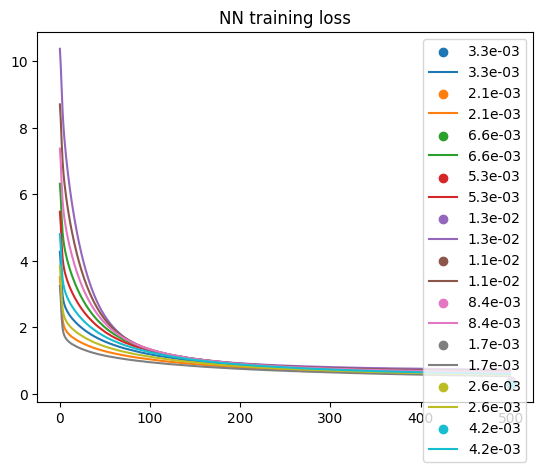

In [623]:
dir_name = f'../experiments/results/FMNIST/15_2/models'

seed = 51
for file in os.listdir(dir_name):
    ds, model,  file_seed, delta = file[:-3].split('_')
    if int(file_seed) != seed:
        continue
    state = torch.load(os.path.join(dir_name, file), map_location=torch.device('cpu'))
    losses = state['losses']
    te_loss = state['metrics']['test_loss']
    plt.scatter(500, te_loss,  label=delta)
    plt.plot(losses, label=delta)
plt.legend()
plt.title('NN training loss')
print(deltas)

In [624]:
np.logspace(-1, 3, 13)

array([1.00000000e-01, 2.15443469e-01, 4.64158883e-01, 1.00000000e+00,
       2.15443469e+00, 4.64158883e+00, 1.00000000e+01, 2.15443469e+01,
       4.64158883e+01, 1.00000000e+02, 2.15443469e+02, 4.64158883e+02,
       1.00000000e+03])

<h2>Run Image experiments </h2>

In [92]:
ds = 'MNIST'
model = 'MLP'
seed = 117

In [96]:
!python3 ../experiments/imgclassification.py -d {ds} -m {model} -s {seed}

Writing results to ../experiments/results/MNIST
Reading data from ../data
Dataset: MNIST
Seed: 117
9920512it [00:00, 12327924.77it/s]                                              
Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw
32768it [00:00, 298645.29it/s]
Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw
1654784it [00:00, 6915425.85it/s]                                               
Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
8192it [00:00, 29604.16it/s]                                                    
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
/Users/tamire1/miniconda3/envs/bnn-env-3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor